In [65]:
import numpy as np

# [ mean(NESS_sites), mean(NESS_site_max), mean(NESS_site_max), mean(max(NESS_sites)), mean(min(NESS_sites)) ]
# for tap, two versions
from VectorMC import *

# extract plot points from NESS
def ness_data(m_hist):
    foo = np.mean(m_hist, axis=-1)
    return [np.mean(foo),np.max(foo),np.min(foo)]

# collect nMF NESS
def nMF_NESS(B,xJm,cs_state, steps=125):
    x0,J,m0 = xJm
    nMF_hist = MNESS_model(B=B,init_x=x0,init_J=J,init_m=m0).single_run(steps)
    if cs_state == 'x':
        cs_state_ = x0
    else:
        cs_state_ = np.ones_like(x0)

    cutoff = 25
    nMF_cs = np.zeros((steps-cutoff,64))
    for t in range(steps):
        if t >= cutoff:
            nMF_cs[t-cutoff] = cos_sim(nMF_hist[t],cs_state_)
    return ness_data(nMF_cs)


# collect TAP NESS
def TAP_NESS(B,xJm,cs_state,steps=200,N=64,D=32):
    x0,J,m0 = xJm
    if cs_state == 'x':
        jcs_state = jnp.array(x0)
    else:
        jcs_state = jnp.array(np.ones_like(x0))
    jsteps = jnp.arange(0, steps)
    mtap_hist = jaxtap(jnp.array(x0),jnp.array(J),jnp.array([m0]),jsteps,B,(D / 2 - 1) ** 0.5)
    cutoff = 50
    y_tap_m_buffer = jnp.zeros_like(mtap_hist[cutoff-1:, :, :, 0])
    for t in jsteps:
        if t >= cutoff:
            y_tap_m_buffer = y_tap_m_buffer.at[t-cutoff].set(optax.cosine_similarity(mtap_hist[t], jcs_state))
    jcs_hist = np.array(y_tap_m_buffer.squeeze()[:-1])
    return ness_data(jcs_hist),ness_data(np.abs(jcs_hist))

# collect MCMC NESS
def MCMC_NESS(B,xJm,cs_state):
    x0,J,m0 = xJm
    if cs_state == 'x':
        cs_state_ = x0
    else:
        cs_state_ = np.ones_like(x0)

    model = VectorSpinMC(B=B,init_xJm=xJm)
    if B <= 1:
        steps = 50
    elif B <= 10:
        steps = 20
    else:
        steps = 10
    m_hist = model.fast_long_run(steps,equilibrate=True)
    #model.plot_TEs2(m_hist)
    ness_state = model.short_run(int(1e4),m_0=m_hist[-1])[-1]
    MCMC_hist = model.fast_long_run(1,m_0=ness_state,equilibrate=False)

    MCMC_cs = np.zeros((len(MCMC_hist),64))
    for t in range(len(MCMC_hist)):
        MCMC_cs[t] = cos_sim(MCMC_hist[t],cs_state_)
    return ness_data(MCMC_cs)


import pandas as pd
def collect_NESS_sites(Bs,xJm,cs_state,verbose=False,toggle_nTM = np.array([1,1,1])):
    start_time = time.time()
    nmf, tap, abstap, mcmc = [],[],[],[]
    for B in Bs:
        if toggle_nTM[0]:
            nMF_data = nMF_NESS(B=B,xJm=xJm,cs_state=cs_state,steps=100)
            nmf.append(nMF_data)
        if toggle_nTM[1]:
            TAP_data, absTAP_data = TAP_NESS(B=B,xJm=xJm,cs_state=cs_state,steps=150)
            tap.append(TAP_data)
            abstap.append(absTAP_data)
        if toggle_nTM[2]:
            MCMC_data = MCMC_NESS(B=B,xJm=xJm,cs_state=cs_state)
            mcmc.append(MCMC_data)
        if verbose:
            print(f'  done NESS for B={float(B)} in {(time.time()-start_time)/60:.2f} minutes')
    nmf, tap, abstap, mcmc = np.array(nmf), np.array(tap), np.array(abstap), np.array(mcmc)
    NESS_dict = {'B': Bs}
    if toggle_nTM[0]:
        NESS_dict['nMF mean'] = nmf[:,0]
        NESS_dict['nMF max'] = nmf[:,1]
        NESS_dict['nMF min'] = nmf[:,2]
    if toggle_nTM[1]:
        NESS_dict['TAP mean'] = tap[:,0]
        NESS_dict['TAP max'] = tap[:,1]
        NESS_dict['TAP min'] = tap[:,2]
        NESS_dict['absTAP mean'] = abstap[:,0]
        NESS_dict['absTAP max'] = abstap[:,1]
        NESS_dict['absTAP min'] = abstap[:,2]
    if toggle_nTM[2]:
        NESS_dict['MCMC mean'] = mcmc[:,0]
        NESS_dict['MCMC max'] = mcmc[:,1]
        NESS_dict['MCMC min'] = mcmc[:,2]

    # NESS_dict = {
    #     'B': Bs,
    #     'nMF mean': nmf[:,0],
    #     'nMF max': nmf[:,1],
    #     'nMF min': nmf[:,2],
    #     'TAP mean': tap[:,0],
    #     'TAP max': tap[:,1],
    #     'TAP min': tap[:,2],
    #     'absTAP mean': abstap[:,0],
    #     'absTAP max': abstap[:,1],
    #     'absTAP min': abstap[:,2],
    #     'MCMC mean': mcmc[:,0],
    #     'MCMC max': mcmc[:,1],
    #     'MCMC min': mcmc[:,2],
    # }
    return pd.DataFrame(NESS_dict)

def plot_NESS_df(ness_df,title='CS(x) of NESS for varying beta',ylabel='Cosine Similarity with x0',absonly=False,toggle_nTM=np.array([1,1,1])):
    plt.figure(figsize=(6,4))
    for ness,color in zip(['nMF','TAP','absTAP','MCMC'],['g','orange','coral','b']):
        if ness == 'nMF' and not toggle_nTM[0]:
            continue
        if ness == 'TAP' and not toggle_nTM[1]:
            continue
        if ness == 'absTAP' and absonly:
            continue
        if ness == 'MCMC' and not toggle_nTM[2]:
            continue
        df = ness_df.loc[:,['B',f'{ness} mean',f'{ness} max', f'{ness} min']].dropna()
        plt.plot(df['B'].values,df[f'{ness} mean'].values,color=color,label=ness,lw=0.3)
        plt.fill_between(df['B'].values,df[f'{ness} max'].values,df[f'{ness} min'].values,color=color,alpha=0.3)
    plt.xscale('log')
    plt.legend()
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('beta')
    plt.show()

new B values:  [0.1, 0.11, 0.12, 0.132, 0.145, 0.159, 0.175, 0.192, 0.21, 0.231, 0.254, 0.278, 0.305, 0.335, 0.368, 0.404, 0.443, 0.486, 0.534, 0.586, 0.643, 0.705, 0.774, 0.85, 0.933, 1.024, 1.123, 1.233, 1.353, 1.485, 1.63, 1.789, 1.963, 2.154, 2.364, 2.595, 2.848, 3.126, 3.43, 3.765, 4.132, 4.535, 4.977, 5.462, 5.995, 6.579, 7.221, 7.925, 8.697, 9.545, 10.476, 11.498, 12.619, 13.849, 15.199, 16.681, 18.307, 20.092, 22.051, 24.201, 26.561, 29.151, 31.993, 35.112, 38.535, 42.292, 46.416, 50.941, 55.908, 61.359, 67.342, 73.907, 81.113, 89.022, 97.701, 107.227, 117.681, 129.155, 141.747, 155.568, 170.735, 187.382, 205.651, 225.702, 247.708, 271.859, 298.365, 327.455, 359.381, 394.421, 432.876, 475.081, 521.401, 572.237, 628.029, 689.261, 756.463, 830.218, 911.163, 1000.0]
  done NESS for B=0.1 in 0.02 minutes
  done NESS for B=0.11 in 0.04 minutes
  done NESS for B=0.12 in 0.05 minutes
  done NESS for B=0.132 in 0.07 minutes
  done NESS for B=0.145 in 0.09 minutes
  done NESS for B=0.15

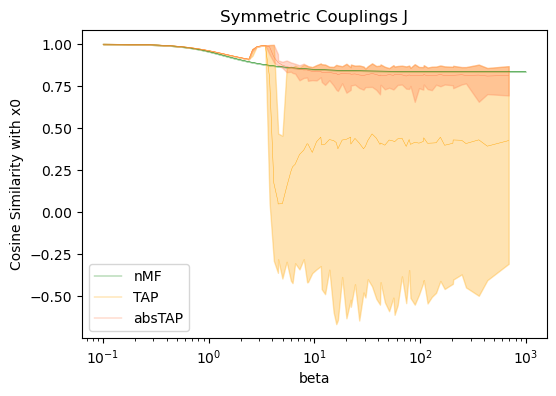

In [64]:
def add_to_NESS_df(Bs,xJm=None,cs_state='x',path='NESS_df_1.csv',verbose=True,toggle_nTM=np.array([1,1,1])):
    # new NESS collection
    if xJm is None:
        xJm = load_generic_xJM()
    print('new B values: ',[float(B) for B in Bs])
    new_ness_df = collect_NESS_sites(Bs,xJm=xJm,cs_state=cs_state,verbose=verbose,toggle_nTM=toggle_nTM)

    # updating NESS collection
    try:
        saved_ness_df = pd.read_csv(f'C:\\Users\\ilove\\PycharmProjects\\MScThesis1_SpinTransformer\\{path}')
        merged_ness_df = saved_ness_df.merge(new_ness_df,how='outer')
        ness_df = merged_ness_df.groupby('B', as_index=False).mean()
        ness_df.to_csv(f'C:\\Users\\ilove\\PycharmProjects\\MScThesis1_SpinTransformer\\{path}',index=False)
        return ness_df
    except FileNotFoundError:
        print(f'creating new file ...\\{path}')
        new_ness_df.to_csv(f'C:\\Users\\ilove\\PycharmProjects\\MScThesis1_SpinTransformer\\{path}',index=False)
        return new_ness_df

# replicas -> many runs


# testing symmetric J
x,J,m = load_generic_xJM()
J_even = 0.5*(J+J.T)
Bs = np.round(np.logspace(-1,3,100,endpoint=True),3)
ndf = add_to_NESS_df(Bs,[x,J_even,m],cs_state='x',path='NESS_J_even_2.csv',toggle_nTM=np.array([1,1,0]))
plot_NESS_df(ndf,title='Symmetric Couplings J',toggle_nTM=np.array([1,1,0]))

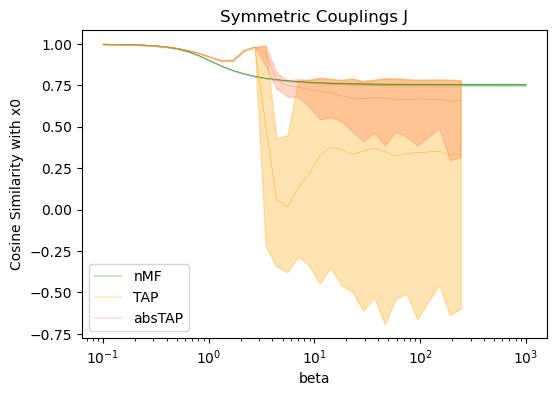

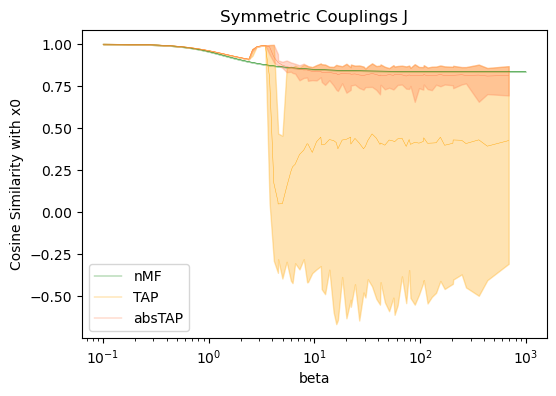

In [66]:
# J_e = |J|*(JJT)/|JJT|
path = 'NESS_J_even_1.csv'
ndf = pd.read_csv(f'C:\\Users\\ilove\\PycharmProjects\\MScThesis1_SpinTransformer\\{path}')
plot_NESS_df(ndf,title='Symmetric Couplings J',toggle_nTM=[1,1,0])

# J_e = 0.5*(JJT)
path = 'NESS_J_even_2.csv'
ndf = pd.read_csv(f'C:\\Users\\ilove\\PycharmProjects\\MScThesis1_SpinTransformer\\{path}')
plot_NESS_df(ndf, title='Symmetric Couplings J', toggle_nTM=[1, 1, 0])

new B values:  [0.1, 0.11, 0.12, 0.132, 0.145, 0.159, 0.175, 0.192, 0.21, 0.231, 0.254, 0.278, 0.305, 0.335, 0.368, 0.404, 0.443, 0.486, 0.534, 0.586, 0.643, 0.705, 0.774, 0.85, 0.933, 1.024, 1.123, 1.233, 1.353, 1.485, 1.63, 1.789, 1.963, 2.154, 2.364, 2.595, 2.848, 3.126, 3.43, 3.765, 4.132, 4.535, 4.977, 5.462, 5.995, 6.579, 7.221, 7.925, 8.697, 9.545, 10.476, 11.498, 12.619, 13.849, 15.199, 16.681, 18.307, 20.092, 22.051, 24.201, 26.561, 29.151, 31.993, 35.112, 38.535, 42.292, 46.416, 50.941, 55.908, 61.359, 67.342, 73.907, 81.113, 89.022, 97.701, 107.227, 117.681, 129.155, 141.747, 155.568, 170.735, 187.382, 205.651, 225.702, 247.708, 271.859, 298.365, 327.455, 359.381, 394.421, 432.876, 475.081, 521.401, 572.237, 628.029, 689.261, 756.463, 830.218, 911.163, 1000.0]
  done NESS for B=0.1 in 0.18 minutes
  done NESS for B=0.11 in 0.31 minutes
  done NESS for B=0.12 in 0.43 minutes
  done NESS for B=0.132 in 0.56 minutes
  done NESS for B=0.145 in 0.71 minutes
  done NESS for B=0.15

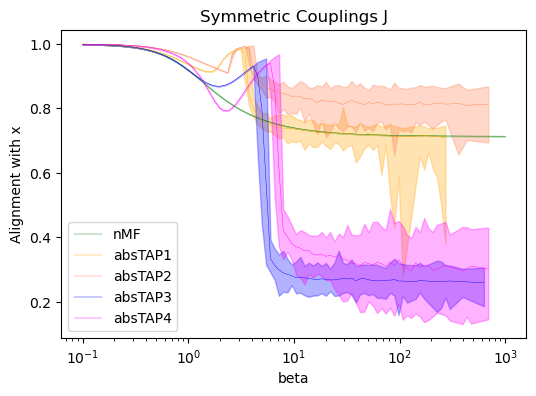

In [8]:
#plotting TAP J_even, TAP J_odd
from VectorMC import *
def ness_data(m_hist):
    foo = np.mean(m_hist, axis=-1)
    return [np.mean(foo),np.max(foo),np.min(foo)]

# collect nMF NESS
def nMF_NESS(B,xJm,cs_state, steps=125):
    x0,J,m0 = load_generic_xJM()
    nMF_hist = MNESS_model(B=B,init_x=x0,init_J=J,init_m=m0).single_run(steps)
    if cs_state == 'x':
        cs_state_ = x0
    else:
        cs_state_ = np.ones_like(x0)

    cutoff = 25
    nMF_cs = np.zeros((steps-cutoff,64))
    for t in range(steps):
        if t >= cutoff:
            nMF_cs[t-cutoff] = cos_sim(nMF_hist[t],cs_state_)
    return ness_data(nMF_cs)

def TAP_NESS_sym(B,steps=200,N=64,D=32,symJ=False):
    x0,J,m0 = load_generic_xJM(N,D)
    if symJ:
        J = 0.5*(J+J.T)
    jcs_state = jnp.array(x0)
    jsteps = jnp.arange(0, steps)
    mtap_hist = jaxtap(jnp.array(x0),jnp.array(J),jnp.array([m0]),jsteps,B,(D / 2 - 1) ** 0.5)
    cutoff = 50
    y_tap_m_buffer = jnp.zeros_like(mtap_hist[cutoff-1:, :, :, 0])
    for t in jsteps:
        if t >= cutoff:
            y_tap_m_buffer = y_tap_m_buffer.at[t-cutoff].set(optax.cosine_similarity(mtap_hist[t], jcs_state))
    jcs_hist = np.array(y_tap_m_buffer.squeeze()[:-1])
    return ness_data(jcs_hist),ness_data(np.abs(jcs_hist))

def collect_NESS_TAP(Bs,verbose=False):
    start_time = time.time()
    nmf, abstap1, abstap2, abstap3, abstap4 = [],[],[],[],[]
    for B in Bs:
        nMF_data = nMF_NESS(B=B,xJm=load_generic_xJM(),cs_state='x',steps=100)
        nmf.append(nMF_data)
        TAP_data, absTAP_data1 = TAP_NESS_sym(B=B,steps=150)
        abstap1.append(absTAP_data1)
        TAP_data, absTAP_data2 = TAP_NESS_sym(B=B,steps=150,symJ=True)
        abstap2.append(absTAP_data2)
        TAP_data, absTAP_data3 = TAP_NESS_sym(B=B,steps=150,N=1024,D=512)
        abstap3.append(absTAP_data3)
        TAP_data, absTAP_data4 = TAP_NESS_sym(B=B,steps=150,symJ=True,N=1024,D=512)
        abstap4.append(absTAP_data4)
        if verbose:
            print(f'  done NESS for B={float(B)} in {(time.time()-start_time)/60:.2f} minutes')
    nmf, abstap1,abstap2,abstap3,abstap4 = np.array(nmf), np.array(abstap1), np.array(abstap2), np.array(abstap3), np.array(abstap4)
    NESS_dict = {'B': Bs}
    NESS_dict['nMF mean'] = nmf[:,0]
    NESS_dict['nMF max'] = nmf[:,1]
    NESS_dict['nMF min'] = nmf[:,2]
    NESS_dict['absTAP1 mean'] = abstap1[:,0]
    NESS_dict['absTAP1 max'] = abstap1[:,1]
    NESS_dict['absTAP1 min'] = abstap1[:,2]
    NESS_dict['absTAP2 mean'] = abstap2[:,0]
    NESS_dict['absTAP2 max'] = abstap2[:,1]
    NESS_dict['absTAP2 min'] = abstap2[:,2]
    NESS_dict['absTAP3 mean'] = abstap3[:,0]
    NESS_dict['absTAP3 max'] = abstap3[:,1]
    NESS_dict['absTAP3 min'] = abstap3[:,2]
    NESS_dict['absTAP4 mean'] = abstap4[:,0]
    NESS_dict['absTAP4 max'] = abstap4[:,1]
    NESS_dict['absTAP4 min'] = abstap4[:,2]
    return pd.DataFrame(NESS_dict)

def add_to_NESS_TAP(Bs,path='NESS_TAP_df_1.csv',verbose=True):
    # new NESS collection
    print('new B values: ',[float(B) for B in Bs])
    new_ness_df = collect_NESS_TAP(Bs,verbose=verbose)
    # updating NESS collection
    try:
        saved_ness_df = pd.read_csv(f'C:\\Users\\ilove\\PycharmProjects\\MScThesis1_SpinTransformer\\{path}')
        merged_ness_df = saved_ness_df.merge(new_ness_df,how='outer')
        ness_df = merged_ness_df.groupby('B', as_index=False).mean()
        ness_df.to_csv(f'C:\\Users\\ilove\\PycharmProjects\\MScThesis1_SpinTransformer\\{path}',index=False)
        return ness_df
    except FileNotFoundError:
        print(f'creating new file ...\\{path}')
        new_ness_df.to_csv(f'C:\\Users\\ilove\\PycharmProjects\\MScThesis1_SpinTransformer\\{path}',index=False)
        return new_ness_df

def plot_NESS_TAP(ness_df,title='Alignment of NESS with x for varying beta',ylabel='Alignment with x'):
    plt.figure(figsize=(6,4))
    for ness,color in zip(['nMF','absTAP1','absTAP2','absTAP3','absTAP4'],['g','orange','coral','b','magenta']):
        df = ness_df.loc[:,['B',f'{ness} mean',f'{ness} max', f'{ness} min']].dropna()
        plt.plot(df['B'].values,df[f'{ness} mean'].values,color=color,label=ness,lw=0.3)
        plt.fill_between(df['B'].values,df[f'{ness} max'].values,df[f'{ness} min'].values,color=color,alpha=0.3)
    plt.xscale('log')
    plt.legend()
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('beta')
    plt.show()

Bs = np.round(np.logspace(-1,3,100,endpoint=True),3)
import pandas as pd
ndf = add_to_NESS_TAP(Bs,path='NESS_symJ_1.csv')
#ndf = pd.read_csv('C:\\Users\\ilove\\PycharmProjects\\MScThesis1_SpinTransformer\\NESS_symJ_1.csv')
plot_NESS_TAP(ndf,title='Symmetric Couplings J')

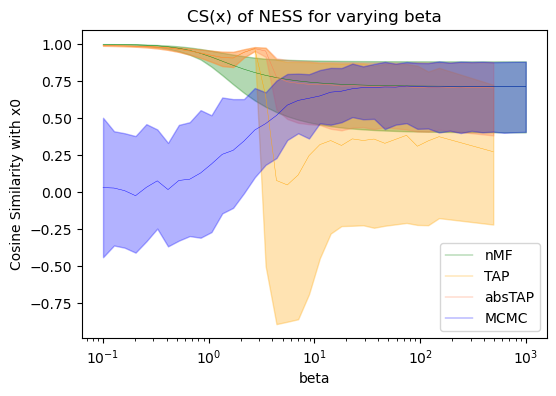

In [5]:
path = 'NESS_df1.csv'
ness_df = pd.read_csv(f'C:\\Users\\ilove\\PycharmProjects\\MScThesis1_SpinTransformer\\{path}')
plot_NESS_df(ness_df)

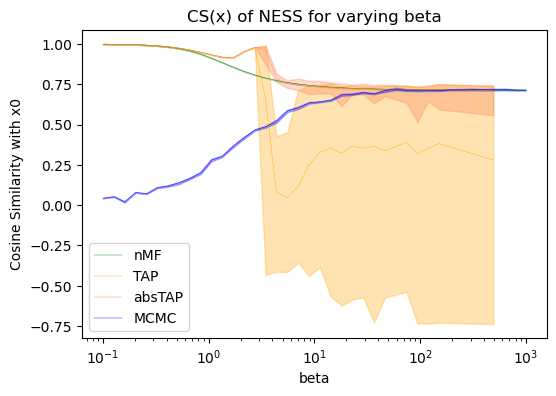

In [46]:
path = 'NESS_mean_0 1x.csv'
ness_df = pd.read_csv(f'C:\\Users\\ilove\\PycharmProjects\\MScThesis1_SpinTransformer\\{path}')
plot_NESS_df(ness_df)

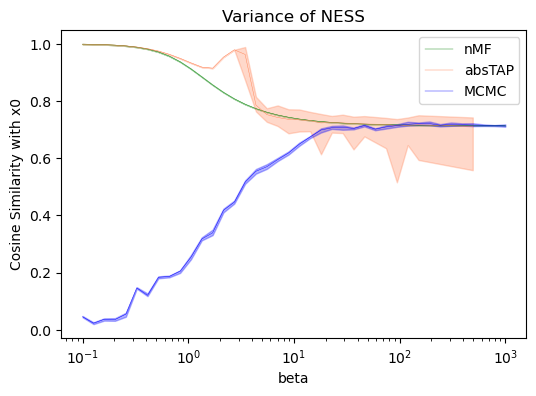

In [41]:
path = 'NESS_mean_df1.csv'
df1 = pd.read_csv(f'C:\\Users\\ilove\\PycharmProjects\\MScThesis1_SpinTransformer\\{path}')
plot_NESS_df(df1,'Variance of NESS',absonly=True)

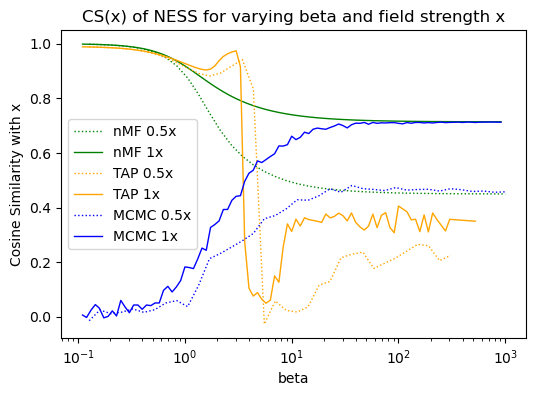

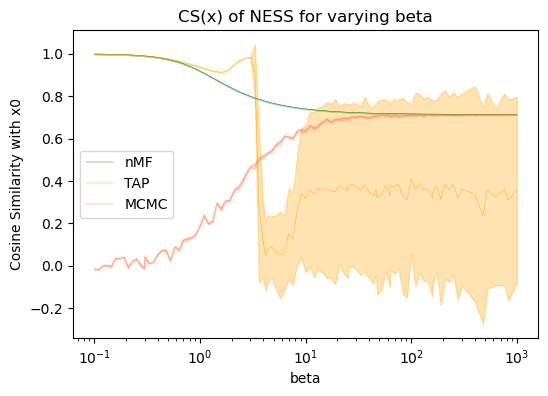

In [12]:

path = 'NESS_0 5x_1.csv'
ness_df_05 = pd.read_csv(f'C:\\Users\\ilove\\PycharmProjects\\MScThesis1_SpinTransformer\\{path}')


path = 'NESS_2.csv'
ness_df_1 = pd.read_csv(f'C:\\Users\\ilove\\PycharmProjects\\MScThesis1_SpinTransformer\\{path}')

plt.figure(figsize=(6,4))
for ness,color in zip(['nMF','TAP','MCMC'],['g','orange','b']):
    df_05 = ness_df_05.loc[:,['B',f'{ness} mean',f'{ness} std']].dropna()
    plt.plot(list(df_05['B']),list(df_05[f'{ness} mean']),ls=':', color=color,label=ness+' 0.5x',lw=1)
    df_1 = ness_df_1.loc[:,['B',f'{ness} mean',f'{ness} std']].dropna()
    plt.plot(list(df_1['B']),list(df_1[f'{ness} mean']),color=color,label=ness+' 1x',lw=1)
plt.xscale('log')
plt.legend()
plt.title('CS(x) of NESS for varying beta and field strength x')
plt.ylabel('Cosine Similarity with x')
plt.xlabel('beta')
plt.show()

path = 'NESS_1.csv'
ness_df = pd.read_csv(f'C:\\Users\\ilove\\PycharmProjects\\MScThesis1_SpinTransformer\\{path}')
plot_NESS_df(ness_df)

In [ ]:
x = 5